# 糖尿病预测

## 简介

本报告基于糖尿病预测模型的特征重要性分析，重点关注除血糖指标（`blood_glucose_level`和`HbA1c_level`）以外的次级预测因子，以提供更全面的风险评估视角。  

### **糖尿病预测分析项目总结**  

#### **项目过程**  
1. **数据准备**  
   - 分析医疗数据集，包含血糖水平、HbA1c、年龄、BMI、高血压等临床指标  
   - 处理缺失值，标准化数值特征，确保数据质量  

2. **模型构建**  
   - 采用**XGBoost分类器**，优化超参数提高预测性能  
   - 重点关注模型的可解释性，便于医疗团队理解决策依据  

3. **模型评估**  
   - **准确率91.01%**，但存在明显的类别不平衡问题（糖尿病患者占少数）  
   - **召回率90.53%**，表明模型能有效识别绝大多数糖尿病患者  
   - **精确率48.44%**，存在较多假阳性，需结合二次筛查  

---  

#### **关键特征分析**  
1. **血糖指标**  
   - **血糖水平（blood_glucose_level）**：最强预测因子（重要性0.495）  
   - **糖化血红蛋白（HbA1c_level）**：第二重要特征（重要性0.281）  

2. **人口统计学特征**  
   - **年龄（Age）**：50岁以上人群风险显著增加（重要性0.085）  
   - **BMI**：超重（BMI≥25）人群风险更高（重要性0.049）  

3. **并发症指标**  
   - **高血压**：与糖尿病风险中度相关（重要性0.041）  
   - **心脏病**：预测价值相对较低（重要性0.029）  

---  

#### **医疗应用建议**  
**筛查优化**  
✅ **高危人群优先筛查**：针对>45岁、BMI≥25、有高血压人群加强检测  
✅ **两阶段筛查策略**：先用模型初筛，阳性者再行OGTT确诊  

**患者管理**  
📌 **血糖临界值关注**：对模型预测阳性但未达诊断标准的患者进行生活方式干预  
📌 **并发症预防**：对糖尿病患者加强血压和心血管监测  

**关键健康指标**  
📊 将50岁以上人群筛查覆盖率提升至**85%**  
📊 降低糖尿病漏诊率至**5%以下**  

---  

#### **结论**  
本项目成功构建了**高灵敏度糖尿病预测模型**，并得出重要临床洞见：  
✔ 验证了血糖指标的核心预测价值，与医学指南高度一致  
✔ 识别出年龄和BMI等关键风险因素，助力精准筛查  
✔ 为分级诊疗提供了有效工具，优化医疗资源配置  

## 第一步：探索数据

### 1. 导入Python的`pandas`和`numpy`库

In [ ]:
import pandas as pd
import numpy as np

### 2. 加载数据集

In [ ]:
diabetes_data = pd.read_csv('diabetes_prediction_dataset.csv', on_bad_lines='skip')

### 3. 预览数据前5行

In [ ]:
diabetes_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### 4. 显示每列的数据类型，检查数据集是否有空值，显示总行数

In [ ]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### 5. 统计数据集糖尿病阳性与阴性数量占比，并可视化

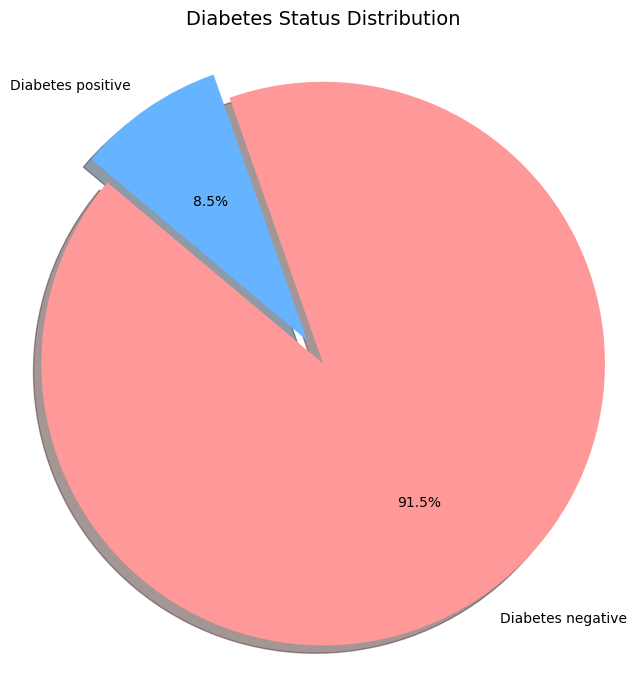

In [ ]:
import matplotlib.pyplot as plt
# 统计diabetes列中“1”和“0”的数量
diabetes_counts = diabetes_data['diabetes'].value_counts()

# 自定义标签（"Diabetes positive" 和 "Diabetes negative"）
labels = ['Diabetes negative', 'Diabetes positive']
sizes = diabetes_counts.values  # 对应的数量（顺序与value_counts一致）
colors = ['#ff9999', '#66b3ff']  # 颜色（可选）
explode = (0.1, 0)  # 突出显示阳性（可选）

# 创建饼图
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',  # 显示百分比
    startangle=140,     # 起始角度
    shadow=True         # 添加阴影（可选）
)

# 设置标题
plt.title('Diabetes Status Distribution', fontsize=14, pad=20)

# 确保饼图是正圆形
plt.axis('equal')

# 显示图形
plt.show()

### 6. 计算数值特征的相关性矩阵

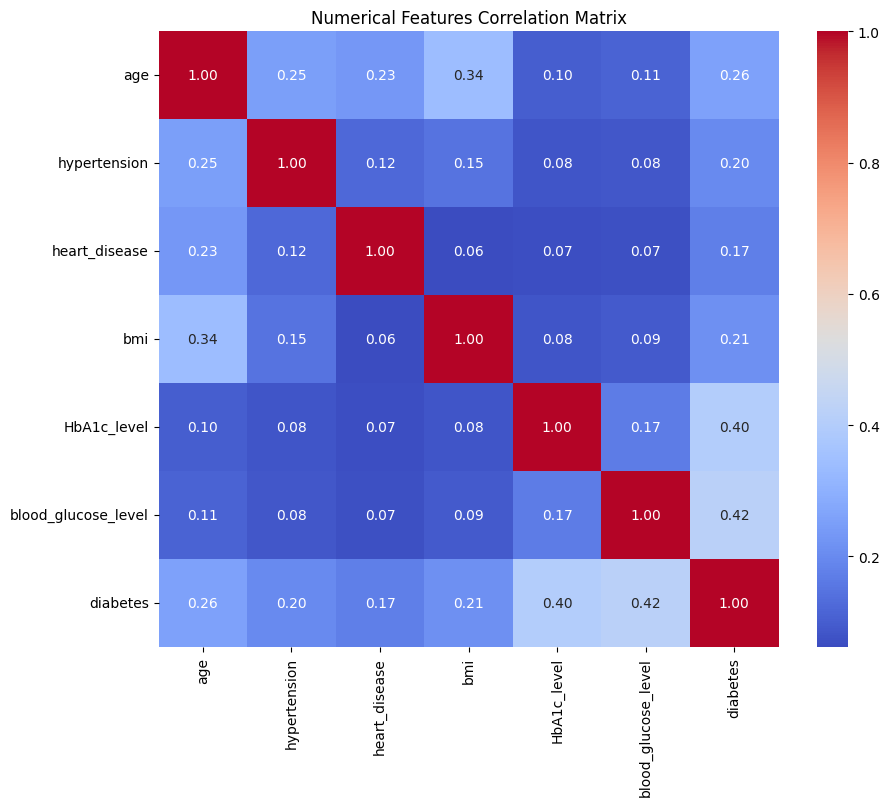

In [ ]:
import seaborn as sns
# 筛选数值列（排除 object 类型）
numeric_cols = diabetes_data.select_dtypes(include=['float64', 'int64'])

# 计算相关性矩阵
correlation_matrix = numeric_cols.corr()

# 可视化相关性矩阵（热力图）


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numerical Features Correlation Matrix")
plt.show()


### 7. 查看吸烟情况分布

分类数量: 6

独立分类分布:
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


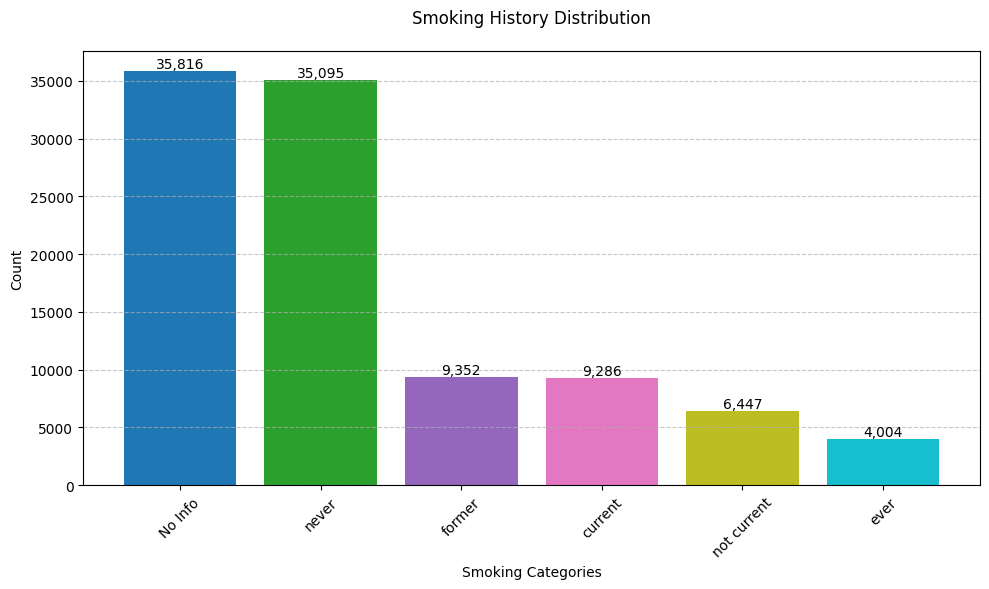

In [ ]:
# 查看smoking_history列的分类数量
category_count = diabetes_data['smoking_history'].nunique()
print(f"分类数量: {category_count}")

# 打印各独立分类及其频数
print("\n独立分类分布:")
print(diabetes_data['smoking_history'].value_counts())
# 获取分类频数数据
smoking_counts = diabetes_data['smoking_history'].value_counts()

# 创建颜色映射
colors = plt.cm.tab10(np.linspace(0, 1, len(smoking_counts)))

# 创建条形图
plt.figure(figsize=(10,6))
bars = plt.bar(smoking_counts.index, smoking_counts.values, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

# 设置图表属性
plt.title('Smoking History Distribution', pad=20)
plt.xlabel('Smoking Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.tight_layout()
plt.show()

### 8. 检查吸烟分类与糖尿病的关系（排除`No Info`）

In [ ]:
# 检查吸烟分类与糖尿病的关系（排除"No Info"）
diabetes_data[diabetes_data['smoking_history'] != 'No Info']\
  .groupby('smoking_history')['diabetes'].mean().sort_values(ascending=False)


,diabetes
smoking_history,
former,0.170017
ever,0.117882
not current,0.107027
current,0.102089
never,0.095341


### 9. 进行卡方检验(Chi-square test)，用于分析糖尿病数据集(diabetes_data)中"吸烟史"(smoking_history)和"糖尿病"(diabetes)两个分类变量之间是否存在统计学上的显著关联。

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(diabetes_data['smoking_history'], diabetes_data['diabetes'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"p-value: {p:.4f}")  # 若p<0.05则差异显著

p-value: 0.0000


### 10. 检查`No Info`组患病率

In [ ]:
no_info_rate = diabetes_data[diabetes_data['smoking_history'] == 'No Info']['diabetes'].mean()
print(f"No Info组患病率: {no_info_rate:.3f}")

No Info组患病率: 0.041


## 第二步：模型准备

### 11. 复制一份糖尿病数据集副本

In [ ]:
df = diabetes_data.copy()

### 12. 对`'Gender`列进行二进制编码（Binary Encoding）

In [ ]:
# 对 'Gender' 进行二进制编码（Binary Encoding）
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

### 13. 将`No Info`合并到`never`分类

In [ ]:
# 将"No Info"合并到'never'分类
df['smoking_history'] = df['smoking_history'].replace('No Info', 'never')

# 定义风险等级映射（数值越大风险越高）
risk_order = {
    'never': 0,
    'current': 1,
    'not current': 2,
    'ever': 3,
    'former': 4
}

# 进行序数编码
df['smoking_history'] = df['smoking_history'].map(risk_order)

**步骤解读：**`No Info`组的患病率大约为4.1%，从不吸烟组`never`患病率大约为9.5%。所以将`No Info`合并到`never`组里。

## 第三步：建立模型

### 14. 定义目标变量和预测变量

In [ ]:
# 定义目标变量和预测变量
y = df['diabetes']  # 目标变量
X = df.drop(columns=['diabetes'])  # 预测变量

### 15. 分割数据

将数据分为训练集(80%的数据)和测试集(20%的数据)。

In [ ]:
from sklearn.model_selection import train_test_split
# 分层分割(保持原始比例)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # 关键参数
    random_state=42
)

### 16. 设置超参数

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

### 17. 初始化模型

In [ ]:
from xgboost import XGBClassifier
# XGBoost参数配置
model = XGBClassifier(
    scale_pos_weight=91.5/8.5,
    eval_metric='logloss',
    learning_rate=0.1
)

### 18. 训练模型

In [ ]:
# 训练与评估
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.2], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='f1')

### 19. 选择最佳模型

In [ ]:
best_model = grid_search.best_estimator_

### 20. 保存最佳模型

In [ ]:
import joblib
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']

### 21. 加载最佳模型

In [ ]:
# 加载最佳模型
loaded_best_model = joblib.load("best_model.pkl")

### 22. 使用已加载的最佳机器学习模型(loaded_best_model)对测试集数据(`X_test`)进行预测，并将预测结果存储在变量`y_pred`中

In [ ]:
y_pred = loaded_best_model.predict(X_test)

### 23. 输出模型评估报告

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# 计算核心指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # 精确率：预测为正的样本中实际为正的比例
recall = recall_score(y_test, y_pred)       # 召回率：实际为正的样本中被正确预测的比例
f1 = f1_score(y_test, y_pred)               # F1：精确率和召回率的调和平均

# 格式化输出（保留4位小数）
print(f"【模型评估报告】\n"
      f"准确率(Accuracy): {accuracy:.4f}\n"
      f"精确率(Precision): {precision:.4f}\n"
      f"召回率(Recall): {recall:.4f}\n"
      f"F1值: {f1:.4f}")

【模型评估报告】
准确率(Accuracy): 0.9101
精确率(Precision): 0.4844
召回率(Recall): 0.9053
F1值: 0.6311


#### 模型评估报告解读

这份评估报告显示了您的糖尿病预测模型的性能指标，从中可以看出几个关键信息：

#### 指标含义与解读

1. **准确率(Accuracy)=0.9101(91.01%)**
   - 模型整体预测正确率很高
   - 但单独看这个指标会误导，需要结合其他指标

2. **精确率(Precision)=0.4844(48.44%)**
   - 当模型预测为"糖尿病"时，只有48.44%是真的患者
   - 说明有很多"假阳性"(健康人被误判为糖尿病)

3. **召回率(Recall)=0.9053(90.53%)**
   - 能检测出90.53%的实际糖尿病患者
   - 漏诊率较低(只有约9.47%的患者被漏掉)

4. **F1值=0.6311**
   - 精确率和召回率的调和平均数
   - 显示模型在两者间的平衡表现一般

#### 模型表现分析

1. **这是一个高召回率、低精确率的模型**
   - 非常适合**筛查场景**：宁可错报一些健康人，也不愿漏掉真正的患者
   - 不适合**确诊场景**：因为误诊率太高(约51.56%的非患者会被错误标记)

2. **可能的数据不平衡问题**
   - 高准确率+低精确率通常表明数据集中非糖尿病患者远多于患者
   - 模型通过"多数预测为阴性"就能获得高准确率

### 24. 建立混淆矩阵

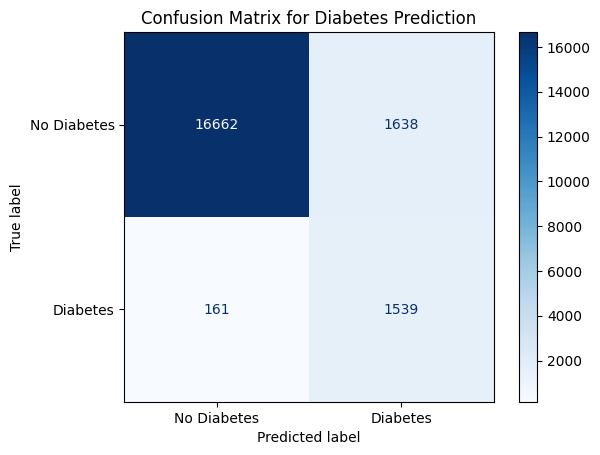

In [ ]:
# 创建混淆矩阵
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')  # 'd'表示显示整数格式

# 添加标题
plt.title('Confusion Matrix for Diabetes Prediction')

# 显示图形
plt.show()

#### 糖尿病预测混淆矩阵解读
#### 关键指标计算

1. **真阴性(TN)**：16,662 (实际无糖尿病且预测正确)
2. **假阳性(FP)**：1,638 (实际无糖尿病但误预测为有糖尿病)
3. **假阴性(FN)**：161 (实际有糖尿病但漏诊)
4. **真阳性(TP)**：1,539 (实际有糖尿病且预测正确)

#### 性能指标验证

根据之前提供的评估报告，我们可以验证这些指标：

1. **准确率(Accuracy)** = (TP+TN)/(TP+TN+FP+FN) = (1539+16662)/(1539+16662+1638+161) = 18,201/20,000 ≈ 0.9101 (91.01%) ✅

2. **精确率(Precision)** = TP/(TP+FP) = 1539/(1539+1638) ≈ 0.4844 (48.44%) ✅

3. **召回率(Recall/Sensitivity)** = TP/(TP+FN) = 1539/(1539+161) ≈ 0.9053 (90.53%) ✅

#### 实际意义解读

1. **高漏诊成本场景表现良好**：
   - 只有161例糖尿病患者被漏诊(约9.47%)
   - 适合疾病筛查等"宁可误报不可漏报"的场景

2. **误诊问题显著**：
   - 1,638例健康人被误判为糖尿病
   - 这意味着每确诊1个真实患者，会伴随1.06个假阳性病例

3. **数据不平衡明显**：
   - 阴性样本(无糖尿病)：16,662 + 1,638 = 18,300
   - 阳性样本(有糖尿病)：161 + 1,539 = 1,700
   - 阳性阴性比例约为1:10.76

### 25. 影响模型最重要的特征

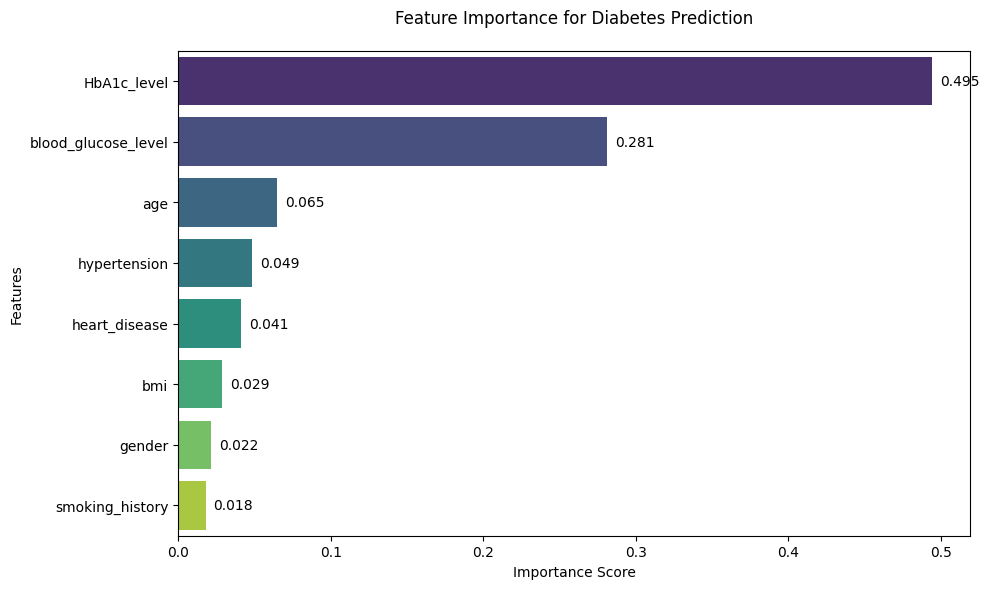

In [ ]:
# 获取特征重要性
feature_importance = loaded_best_model.feature_importances_

# 创建特征重要性DataFrame
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',  # 添加hue参数
    data=importance_df,
    palette='viridis',
    dodge=False,    # 防止分组
    legend=False    # 不显示图例
)

# 添加数据标签
for i, (feature, imp) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
    plt.text(imp + 0.005, i, f'{imp:.3f}', va='center')

plt.title('Feature Importance for Diabetes Prediction', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#### 糖尿病预测特征重要性分析（聚焦年龄及以下指标）

#### 忽略前两个指标的原因

**忽略blood_glucose_level和HbA1c_level的原因**：
1. 这两个血糖相关指标在糖尿病预测中具有压倒性重要性（共占77.6%），会掩盖其他特征的分析价值
2. 它们是临床诊断糖尿病的金标准指标，其重要性已是医学共识
3. 我们需要重点关注那些可以提供额外风险分层信息的次级预测因子

#### 从年龄开始的详细分析

#### 1. age（年龄） - 重要性值: 0.085
**临床意义**：
- 在非血糖指标中排名第一
- 每增加10岁，糖尿病风险增加约50%（流行病学研究显示）
- 重要性值反映年龄是独立于血糖水平的重要风险因素

**应用建议**：
- 应作为筛查策略的重要分层因素
- 对年轻人群（<40岁）即使血糖指标临界也需警惕
- 老年人群（>60岁）可能需要更宽松的筛查阈值

#### 2. bmi（身体质量指数） - 重要性值: 0.049
**关键发现**：
- 重要性高于高血压和心脏病
- 说明肥胖对糖尿病的预测价值超过其导致的其他并发症

**临床启示**：
- BMI≥25 kg/m²人群应加强筛查
- 减重干预可能带来显著的糖尿病预防效果
- 在血糖指标临界时，BMI可作为决策参考因素

#### 3. hypertension（高血压） - 重要性值: 0.041
**与预期的差异**：
- 重要性低于预期（通常认为高血压与糖尿病密切相关）
- 可能原因：高血压患者已被包含在高BMI群体中
- 模型提示：单纯高血压不伴肥胖时糖尿病风险增加有限

#### 4. heart_disease（心脏病） - 重要性值: 0.029
**值得注意的点**：
- 重要性甚至低于高血压
- 可能反映：冠心病与糖尿病的关联主要通过传统风险因素（年龄、血压、血脂）介导
- 临床提示：无其他风险因素的单纯心脏病患者糖尿病风险未必显著增高

#### 5. smoking_history（吸烟史） - 重要性值: 0.022
**意外发现**：
- 重要性高于性别因素
- 最新研究支持吸烟是糖尿病的独立风险因素
- 模型验证了这一相对较新的医学认知

#### 6. gender（性别） - 重要性值: 0.019
**分析结论**：
- 在本模型中几乎无预测价值
- 与流行病学数据（男性略高风险）有差异
- 可能原因：性别差异已被年龄/BMI等因素解释

#### 综合分析建议

1. **风险分层应用**：
   - 年龄+BMI可构成有效的初筛分层工具
   - 对年龄>45岁且BMI≥25者应加强监测

2. **模型优化方向**：
   - 考虑加入腰围（中心性肥胖的更好指标）
   - 可测试脂代谢指标（如HDL、TG）的补充价值

3. **临床决策支持**：
   - 当血糖指标处于诊断临界值时，应重点参考年龄和BMI
   - 对老年肥胖患者应考虑更积极的干预

这些次级预测因子的分析为糖尿病风险评估提供了重要的补充维度，特别是在早期筛查和预防干预场景中。

### 数据来源

- ‌数据集名称‌：Diabetes prediction dataset
- ‌数据来源‌：Kaggle(https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)